In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sys

from sklearn.preprocessing import StandardScaler 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score 

import warnings 
warnings.filterwarnings('ignore')


### 1.Data Loading and Cleaning

In [3]:
print("Load the dataset")
df=pd.read_excel("Online Retail.xlsx")
print("The Dataset will be:\n",df)

Load the dataset
The Dataset will be:
        InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

               InvoiceDate  UnitPric

1.1 Basic info

In [4]:
print("\nDataset info")
print(df.info())
print("\nPrint top 5 row")
print(df.head())


Dataset info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None

Print top 5 row
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANG

1.2  Handle missing values

In [5]:
df.dropna(subset=['CustomerID'],inplace=True) # Drop rows without CustomerID
df=df[df['Quantity']>0] # Remove returns/negative quantities
df=df[df['UnitPrice']>0] # Remove zero/negative prices

1.3 Add Feature  column

In [6]:
df['TotalPrice']=df['Quantity']*df['UnitPrice']

# Convert InvoiceDate to datetime
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'])


In [7]:
print("\nCleaned Dataset Shape:", df.shape)


Cleaned Dataset Shape: (397884, 9)


### 3. Exploratory Data Analysis (EDA)

In [8]:
print("\n EDA-Summary Statitics\n")
print(df.describe())


 EDA-Summary Statitics

            Quantity                    InvoiceDate      UnitPrice  \
count  397884.000000                         397884  397884.000000   
mean       12.988238  2011-07-10 23:41:23.511023360       3.116488   
min         1.000000            2010-12-01 08:26:00       0.001000   
25%         2.000000            2011-04-07 11:12:00       1.250000   
50%         6.000000            2011-07-31 14:39:00       1.950000   
75%        12.000000            2011-10-20 14:33:00       3.750000   
max     80995.000000            2011-12-09 12:50:00    8142.750000   
std       179.331775                            NaN      22.097877   

          CustomerID     TotalPrice  
count  397884.000000  397884.000000  
mean    15294.423453      22.397000  
min     12346.000000       0.001000  
25%     13969.000000       4.680000  
50%     15159.000000      11.800000  
75%     16795.000000      19.800000  
max     18287.000000  168469.600000  
std      1713.141560     309.071041  


 3.1 Check for duplicates

In [9]:
print("\n To check the Number of Duplicates\n",df.isnull().sum())
df.drop_duplicates(inplace=True)


 To check the Number of Duplicates
 InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
TotalPrice     0
dtype: int64


3.2 Unique values

In [10]:
print("\nUnique Customers:",df["CustomerID"].nunique())
print("\nUnique Country:",df['Country'].nunique())



Unique Customers: 4338

Unique Country: 37


### 4.Data Visualizations

Distribution of Quantity and UnitPrice

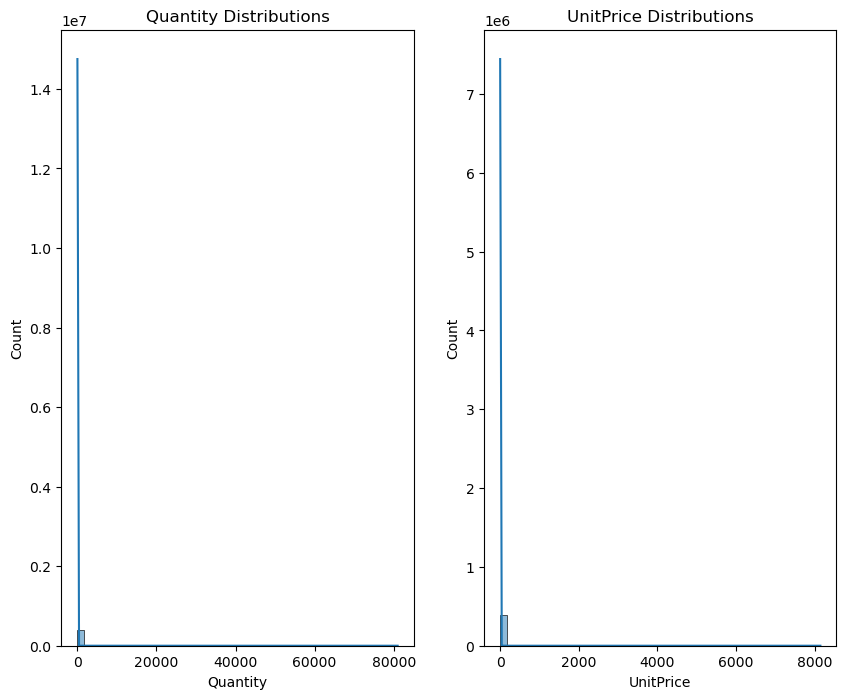

In [11]:
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
sys.histplot(df['Quantity'],bins=50,kde=True)
plt.title("Quantity Distributions")

plt.subplot(1,2,2)
sys.histplot(df['UnitPrice'],bins=50,kde=True)
plt.title("UnitPrice Distributions")
plt.savefig("distribution.png")
plt.show()

4.1  Box plots for outliers

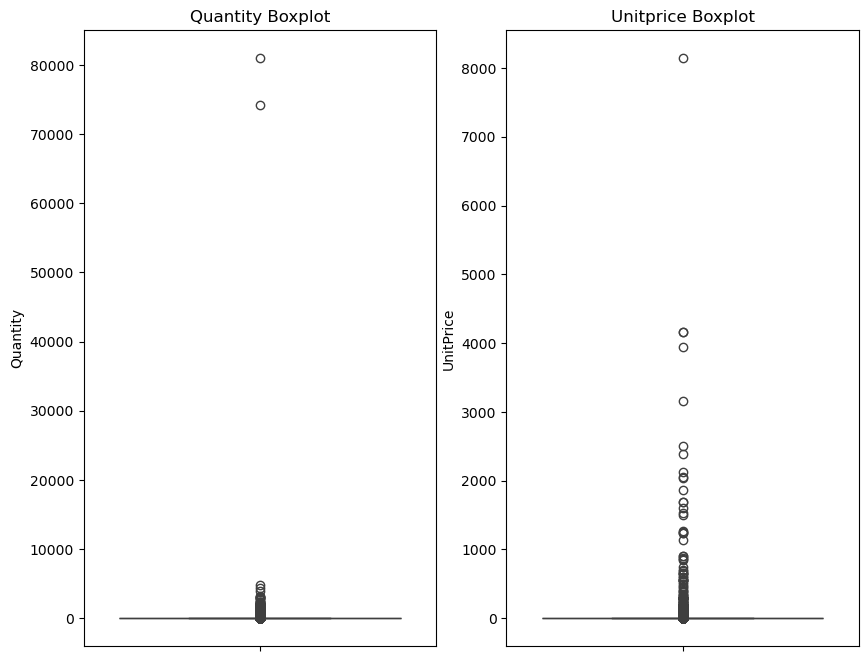

In [12]:
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
sys.boxplot(y=df['Quantity'])
plt.title("Quantity Boxplot")

plt.subplot(1,2,2)
sys.boxplot(y=df['UnitPrice'])
plt.title("Unitprice Boxplot")
plt.savefig("Quantity_Unitprice_Boxplots.png")
plt.show()

4.2 Top 10 Countries by Transactions

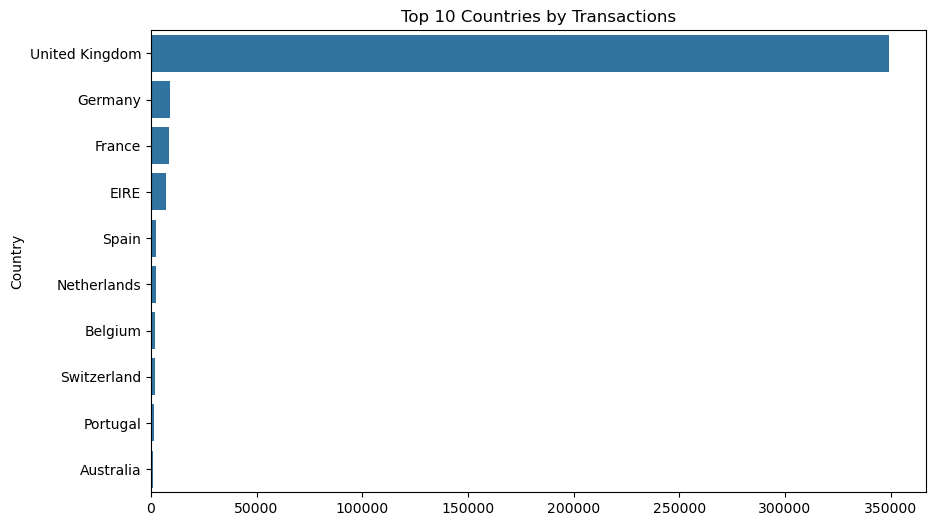

In [13]:
top_countries = df['Country'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sys.barplot(x=top_countries.values, y=top_countries.index)
plt.title('Top 10 Countries by Transactions')
plt.savefig('top_countries.png')
plt.show()

### 5.Feature Engineering - RFM Analysis

In [14]:
print("\nComputing the RFM Features")

# Set reference date (one day after last invoice)
referece_date=df['InvoiceDate'].max()+pd.Timedelta(days=1)

# Group by CustomerID
rfm=df.groupby('CustomerID').agg({
    'InvoiceDate':lambda x: (referece_date-x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()

rfm.columns=['CustomerId','Recency','Frequency','Monetary']

# Handle log transformation for skewed data
rfm['Recency']=np.log1p(rfm['Recency'])
rfm['Frequency']=np.log1p(rfm['Frequency'])
rfm['Monetary']=np.log1p(rfm['Monetary'])

print("\nrfm Head\n")
print(rfm.head())


Computing the RFM Features

rfm Head

   CustomerId   Recency  Frequency   Monetary
0     12346.0  5.789960   0.693147  11.253955
1     12347.0  1.098612   2.079442   8.368925
2     12348.0  4.330733   1.609438   7.494564
3     12349.0  2.995732   0.693147   7.472245
4     12350.0  5.739793   0.693147   5.815324


##### 6.1 Visualize RFM Distributions

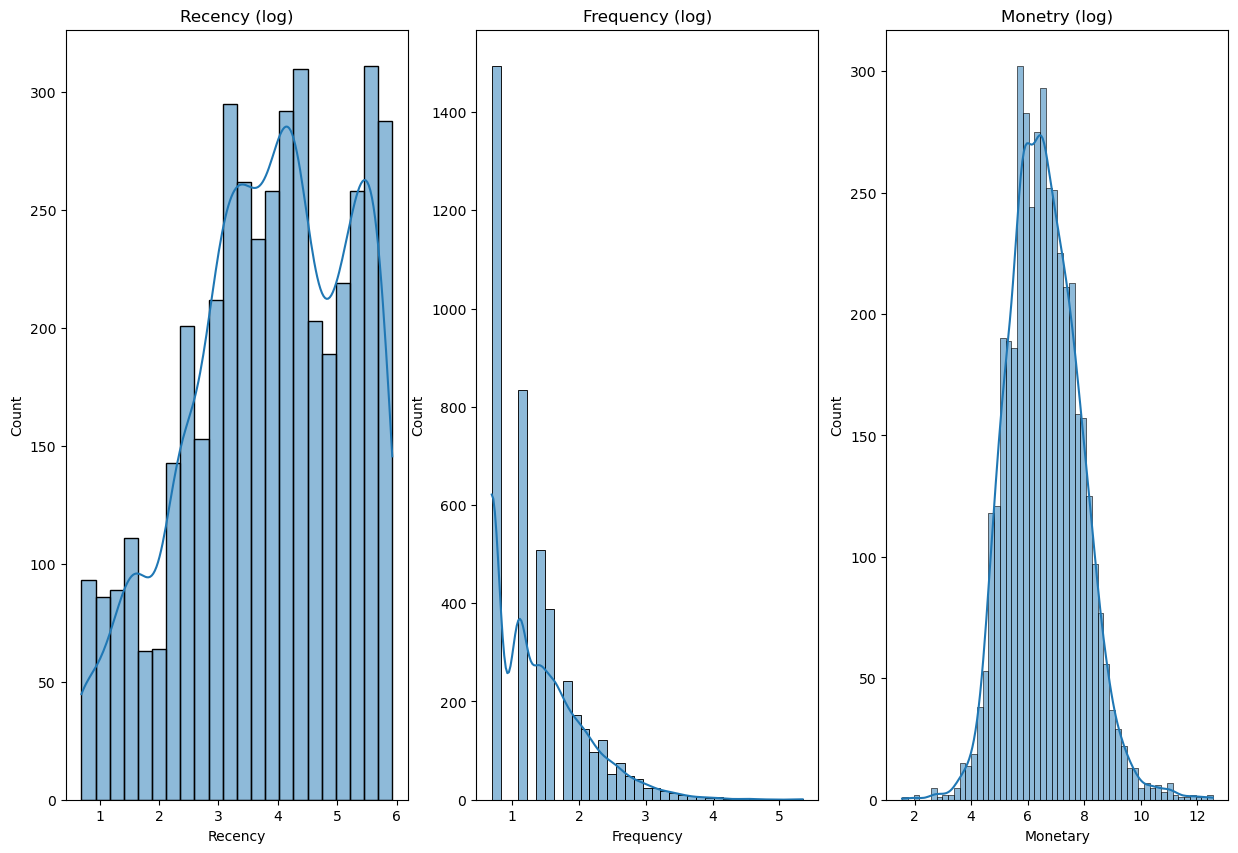

In [15]:
plt.figure(figsize=(15,10))
plt.subplot(1,3,1)
sys.histplot(rfm['Recency'],kde=True)
plt.title('Recency (log)')

plt.subplot(1,3,2)
sys.histplot(rfm['Frequency'],kde=True)
plt.title("Frequency (log)")

plt.subplot(1,3,3)
sys.histplot(rfm['Monetary'],kde=True)
plt.title("Monetry (log)")
plt.savefig("rfm_dstributions.png")
plt.show()

6.2  Scatter plots for RFM relationships

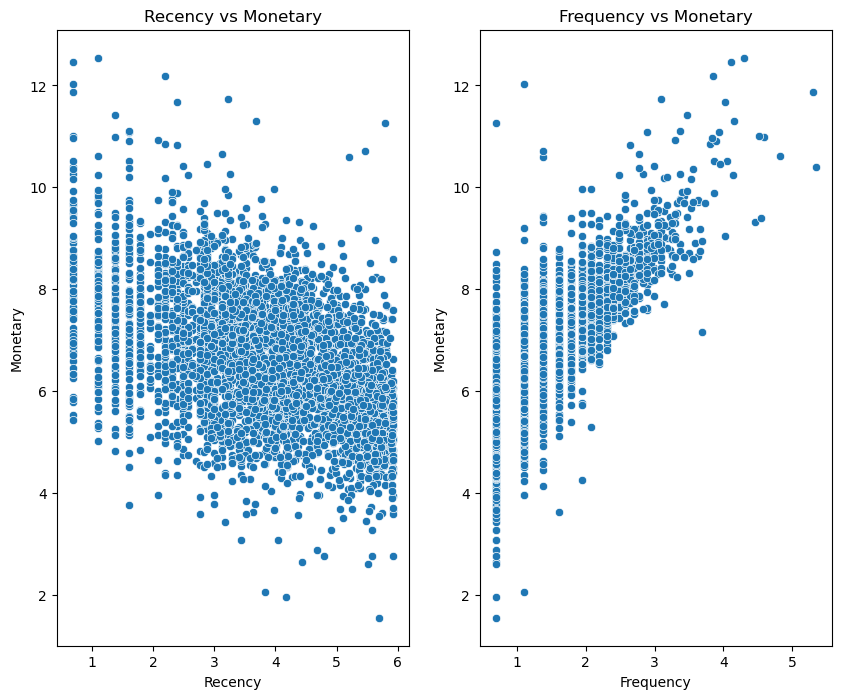

In [16]:
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
sys.scatterplot(x='Recency',y='Monetary',data=rfm)
plt.title("Recency vs Monetary")

plt.subplot(1,2,2)
sys.scatterplot(x='Frequency',y='Monetary',data=rfm)
plt.title('Frequency vs Monetary')
plt.savefig('rfm_scatter.png')
plt.show()

##### Scale RFM features

In [17]:
Scaler=StandardScaler()
rfm_scaled=Scaler.fit_transform(rfm[['Recency','Frequency','Monetary']])

# For Cosine similarity approximation: Normalize to unit length
rfm_normalized=rfm_scaled/np.linalg.norm(rfm_scaled,axis=1,keepdims=True)

### 4. K-Means Clustering

In [18]:

print("\nApplying K-Means clustering...")

kmeans = KMeans(n_clusters=4, random_state=42)
rfm["Cluster"] = kmeans.fit_predict(rfm_scaled)


Applying K-Means clustering...


4.1 Silhouette score

In [19]:
# Silhouette score
sil_score = silhouette_score(rfm_scaled, rfm["Cluster"])
print("Silhouette Score:", sil_score)

Silhouette Score: 0.33481054874687505


### 5. Visualization

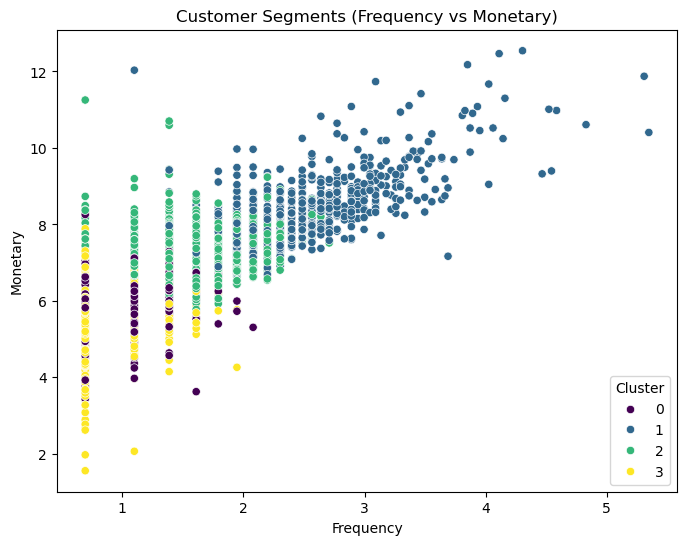

In [20]:

plt.figure(figsize=(8, 6))
sys.scatterplot(
    x=rfm["Frequency"],
    y=rfm["Monetary"],
    hue=rfm["Cluster"],
    palette="viridis"
)
plt.title("Customer Segments (Frequency vs Monetary)")
plt.show()


### 7.Elbow Method

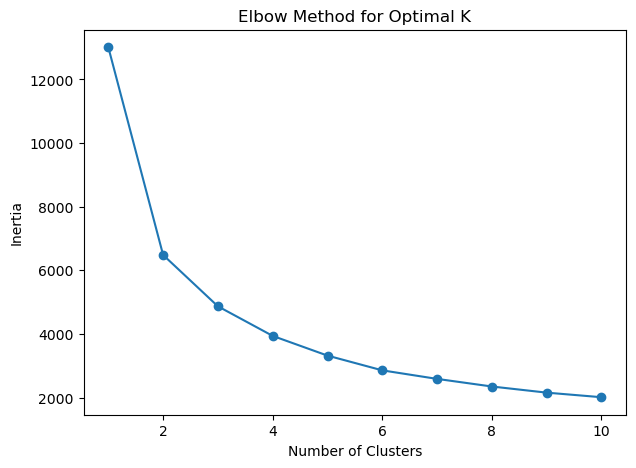

In [21]:
inertia=[]

for k in range(1,11):
    km=KMeans(n_clusters=k,random_state=42)
    km.fit(rfm_scaled)
    inertia.append(km.inertia_)

plt.figure(figsize=(7, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.savefig("Elbow_Method.png")
plt.show()


#### 8 Cluster Profiling 

Shows what each cluster means in business terms.

In [22]:
cluster_summary=rfm.groupby('Cluster').mean()
print(cluster_summary)

           CustomerId   Recency  Frequency  Monetary
Cluster                                             
0        15417.047897  2.789632   1.049916  6.016609
1        15221.424328  2.126749   2.480790  8.350906
2        15206.315612  3.944466   1.584794  7.263003
3        15342.859119  5.064148   0.821703  5.610199


### 9.Customer Count per Cluster

Shows distribution clearly.

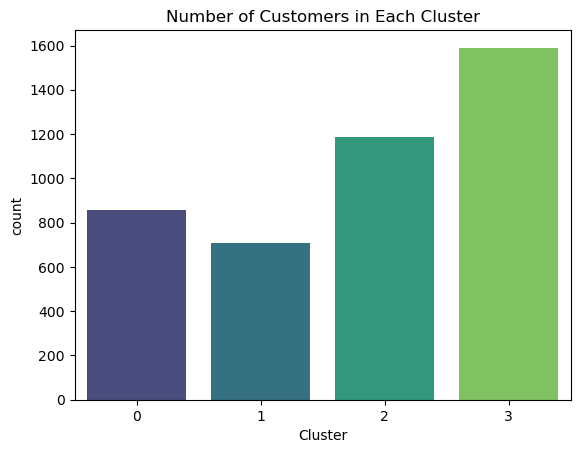

In [23]:
sys.countplot(x='Cluster',data=rfm,palette='viridis')
plt.title("Number of Customers in Each Cluster")
plt.savefig("No_of_Custeromers.png")
plt.show()

### 9.2 Rename Clusters 

This makes your project look professional.

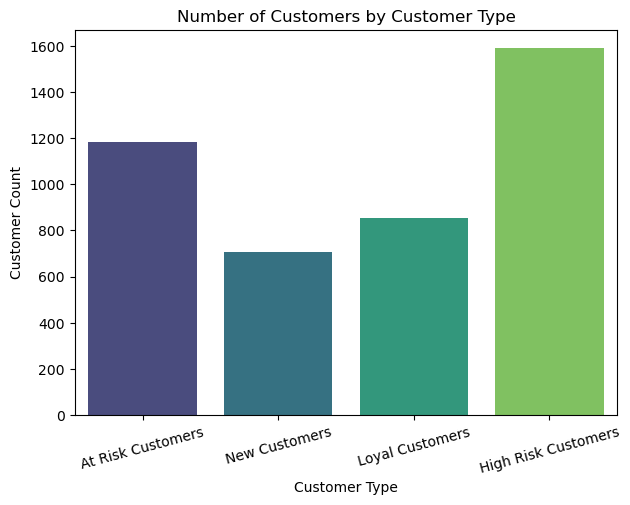

In [24]:
Cluster_names={
    0:'Loyal Customers',
    1:'New Customers',
    2:'At Risk Customers',
    3:'High Risk Customers'
}
rfm["Customer_Type"] = rfm["Cluster"].map(Cluster_names)
#rfm['Customer_Type']

plt.figure(figsize=(7, 5))
sys.countplot(
    x="Customer_Type",
    data=rfm,
    palette="viridis"
)
plt.title("Number of Customers by Customer Type")
plt.xlabel("Customer Type")
plt.ylabel("Customer Count")
plt.xticks(rotation=15)
plt.show()


#• Loyal Customers: Reward with loyalty programs
#• High Value Customers: Offer premium deals
#• At Risk Customers: Send discount offers
#• New Customers: Engagement campaigns


9.3 Average Spending (Monetary) by Customer Type

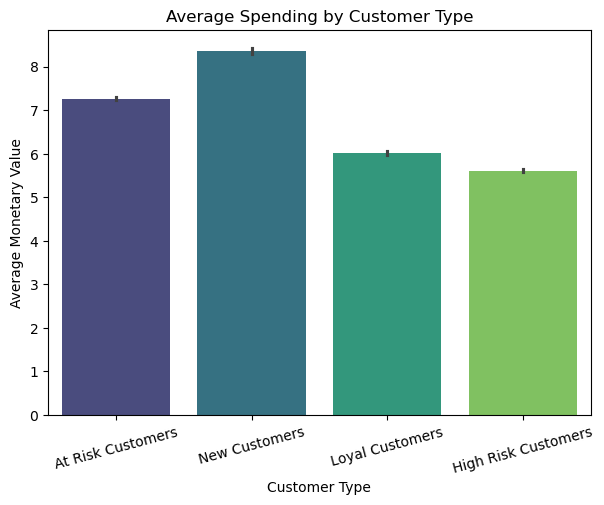

In [25]:
plt.figure(figsize=(7, 5))
sys.barplot(
    x="Customer_Type",
    y="Monetary",
    data=rfm,
    palette="viridis"
)
plt.title("Average Spending by Customer Type")
plt.xlabel("Customer Type")
plt.ylabel("Average Monetary Value")
plt.savefig("Avg_Spending.png")
plt.xticks(rotation=15)
plt.show()


9.4 Purchase Frequency by Customer Type

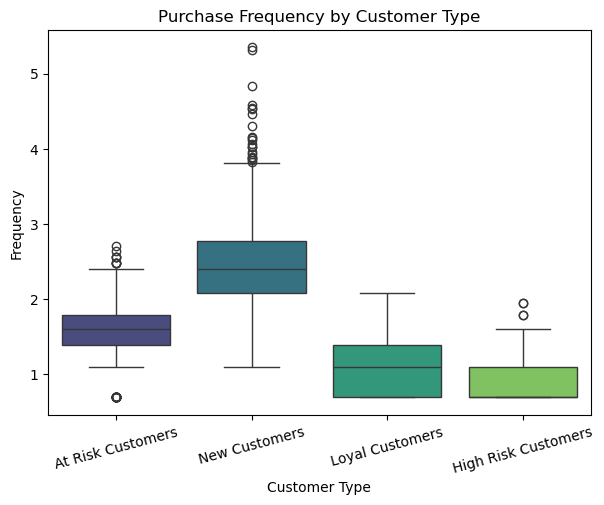

In [26]:
plt.figure(figsize=(7, 5))
sys.boxplot(
    x="Customer_Type",
    y="Frequency",
    data=rfm,
    palette="viridis"
)
plt.title("Purchase Frequency by Customer Type")
plt.xlabel("Customer Type")
plt.ylabel("Frequency")
plt.savefig("Purchase_Frequent.png")
plt.xticks(rotation=15)
plt.show()


9.4 Recency Comparison (Customer Activity)  
“Lower recency means customers purchased more recently.”

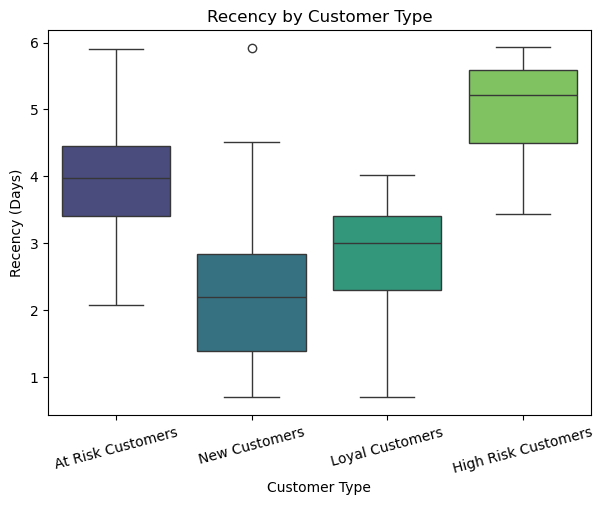

In [27]:
plt.figure(figsize=(7, 5))
sys.boxplot(
    x="Customer_Type",
    y="Recency",
    data=rfm,
    palette="viridis"
)
plt.title("Recency by Customer Type")
plt.xlabel("Customer Type")
plt.ylabel("Recency (Days)")
plt.savefig("Rececy_customer_Type.png")
plt.xticks(rotation=15)
plt.show()


9.5 Pie Chart – Customer Distribution by Customer Type

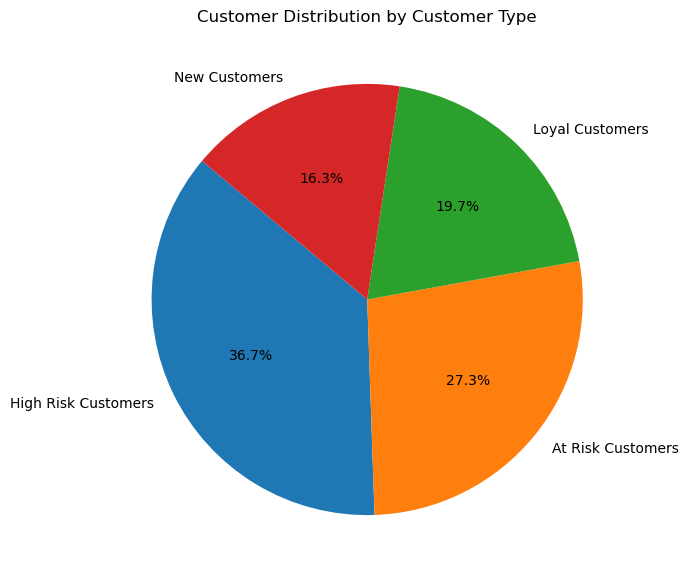

In [30]:
plt.figure(figsize=(7, 7))

customer_counts = rfm["Customer_Type"].value_counts()

plt.pie(
    customer_counts,
    labels=customer_counts.index,
    autopct="%1.1f%%",
    startangle=140
)

plt.title("Customer Distribution by Customer Type")
plt.savefig("Customer_Distribution Using Piechart.png")
plt.show()
#“The pie chart shows the percentage distribution of customers across different customer segments.”

### 10. Save Results

In [29]:
rfm.to_csv("simple_rfm_clusters.csv", index=False)
print("\nClustering complete. Results saved to simple_rfm_clusters.csv")


Clustering complete. Results saved to simple_rfm_clusters.csv
